**Text classification of IMDB movie summaries**

Load in common libraries, most importanly Tensorflow:

In [1]:
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Load in the data I scraped from IMDB. It contains 2100 movie descriptions from 3 genres (crime, romance, and sci-fi). 1680 (80%) are used for training, the remaining to test.

In [2]:
url = "https://github.com/cookm346/imdb_summary_scraper/raw/master/imdb_summaries_3_class.tar.gz"

dataset = tf.keras.utils.get_file("imdb_summaries_3_class.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'imdb_summaries_3_class')

In [3]:
os.listdir(dataset_dir)

['train', 'test']

In [4]:
dataset_dir

'./imdb_summaries_3_class'

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['crime', 'sci-fi', 'romance']

In [6]:
sample_file = os.path.join(train_dir, 'sci-fi/1.txt')
with open(sample_file) as f:
  print(f.read())


    When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence.


In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 1680 files belonging to 3 classes.
Using 1344 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"\n    A human soldier is sent from 2029 to 1984 to stop an almost indestructible cyborg killing machine, sent from the same year, which has been programmed to execute a young woman whose unborn son is the key to humanity's future salvation."
Label 2
Review b'\n    In the midst of a searing Florida heat wave, a woman persuades her lover, a small-town lawyer, to murder her rich husband.'
Label 0
Review b'\n    Two youngsters from rival New York City gangs fall in love, but tensions between their respective friends build toward tragedy.'
Label 1


In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])

Label 0 corresponds to crime
Label 1 corresponds to romance
Label 2 corresponds to sci-fi


I'll take 20% of the training set and use it for a validation set:)

In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 1680 files belonging to 3 classes.
Using 336 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

Found 420 files belonging to 3 classes.


I'll preprocess the text:

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '\n', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 1000
sequence_length = 30

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The model will train the learn to classify the movies' genre from it's summary. To do this, the model basically averages each word vector for a given summary (i.e., computes the semantic gist of each summary). The model also simultaneously builds word embeddings. Using 80% dropout prevents overfitting to some degree.

In [18]:
embedding_dim = 30

In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.8),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.8),
  layers.Dense(3, activation="softmax")])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          30030     
_________________________________________________________________
dropout (Dropout)            (None, None, 30)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 93        
Total params: 30,123
Trainable params: 30,123
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [21]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/100
42/42 [==============================] - 0s 11ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.3326 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.3274
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.3653 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.3482
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 1.0915 - sparse_categorical_accuracy: 0.4003 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.3929
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.3876 - val_loss: 1.0942 - val_sparse_categorical_accuracy: 0.4196
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0904 - sparse_categorical_accuracy: 0.4048 - val_loss: 1.0923 - val_sparse_categorical_accuracy: 0.4107
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0846 - sparse_categorical_acc

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

The plots below show the training and validation loss and accuracy:

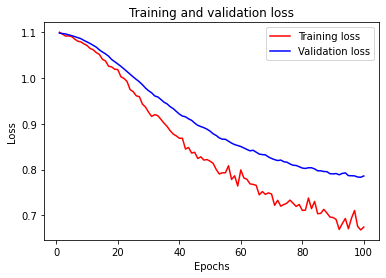

In [23]:
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

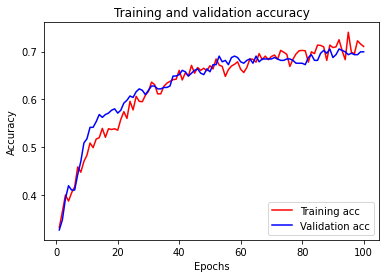

In [24]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Finally, I evaluate the model on the test set:

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

14/14 [==============================] - 0s 3ms/step - loss: 0.7459 - sparse_categorical_accuracy: 0.6762
Loss:  0.745868444442749
Accuracy:  0.6761904954910278


In [26]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

Lastly, the confusion matrix shows the confuability of the 3 classes (crime, romance, sci-fi).

In [27]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(test_ds), axis=-1)  #model.predict_classes() is depreciated
cm = confusion_matrix(y_test, y_pred)
cm

array([[92, 35, 13],
       [30, 94, 16],
       [23, 19, 98]])